# 0. Libraries

In [101]:
import os
import optuna
import pickle
import warnings

import pandas as pd
import numpy  as np
import tqdm   as notebook_tqdm

from utils                   import *
from sklearn.linear_model    import LogisticRegression
from xgboost                 import XGBClassifier
from sklearn.metrics         import roc_auc_score

# warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

## 0.1. Settings parameters

### 0.1.1. Seed

In [ ]:
# seed
seed = 42

### 0.1.2. Paths

In [103]:
# Obtém o diretório de trabalho atual (onde o notebook está localizado)
actual_path = os.getcwd()

# Obtém o diretório raiz de trabalho atual
root_path = os.path.abspath(os.path.join(actual_path, "..", ".."))

# Obtém o diretório pai (um nível acima)
parent_path = os.path.dirname(actual_path)

# Extrai o nome da pasta do diretório pai
parent_folder_name = os.path.basename(parent_path)

print(f"Nome da pasta pai: {parent_folder_name}")

Nome da pasta pai: PROJECT_17


# 1. Data

In [104]:
# loading train abt
abt_train_01 = pd.read_csv(f'{root_path}/{parent_folder_name}/DATAS/GOLD/abt_train_01_{parent_folder_name}.csv')

# checking
abt_train_01.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,PAYMENT_RATE,CREDIT_TO_GOODS_RATIO,MIN_DEBT_CREDIT_DIFF_B,DAYS_BIRTH,INCOME_TO_EMPLOYED_RATIO,SUM_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_DEBT_B,SUM_BUREAU_CREDIT_DEBT_RATIO_B,...,var_19,MAX_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_OVERDUE_B,var_49,AVG_ENDDATE_DIFF_B,MIN_BUREAU_CREDIT_FACT_DIFF_B,AVG_CREDIT_ACTIVE_Sold_DAYS_CREDIT_ENDDATE_B,var_47,SUM_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_B,SUM_CREDIT_TYPE_Consumer_credit_CNT_CREDIT_PROLONG_B,TARGET
0,9.388575e-01,-0.330462,1.739545,-0.493629,0.289744,0.547377,-1.562639,0.254763,-2.725533e-02,-0.007905,...,-1.139534,-1.743356e-02,-1.378984,4.114110e-17,2.667306e-16,0.016551,-0.997497,-0.643717,-0.07874,0
1,-6.373303e-16,-1.950521,0.000000,2.039525,0.074927,0.000000,-0.053120,-0.060507,-3.678960e-18,0.000000,...,0.415795,-2.906674e-18,0.611346,4.114110e-17,2.667306e-16,0.000000,-0.589655,0.000000,0.00000,0
2,-6.373303e-16,0.142739,0.000000,-0.655337,0.611970,0.000000,0.907441,0.059470,-3.678960e-18,0.000000,...,1.553617,-2.906674e-18,-0.078582,4.114110e-17,2.667306e-16,0.000000,-0.948428,0.000000,0.00000,1
3,1.370500e+00,0.678846,0.000000,-0.165864,-0.999158,0.490580,0.849295,0.159750,-2.725533e-02,-0.008741,...,1.441790,-1.743356e-02,0.301569,-2.271842e-02,-6.782917e-01,0.016551,0.093008,-0.643717,-0.07874,0
4,1.217635e+00,-2.140040,-0.469618,-0.165864,-0.999158,-0.177590,0.796185,0.001501,-2.725533e-02,-0.007056,...,1.067252,-1.743356e-02,-1.271498,-3.057576e-01,8.068450e-01,0.016551,0.178394,0.000551,-0.07874,0


In [105]:
# loading test abt
abt_test_01 = pd.read_csv(f'{root_path}/{parent_folder_name}/DATAS/GOLD/abt_test_01_{parent_folder_name}.csv')

# checking
abt_test_01.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,PAYMENT_RATE,CREDIT_TO_GOODS_RATIO,MIN_DEBT_CREDIT_DIFF_B,DAYS_BIRTH,INCOME_TO_EMPLOYED_RATIO,SUM_CREDIT_TYPE_Microloan_AMT_CREDIT_SUM_DEBT_B,SUM_BUREAU_CREDIT_DEBT_RATIO_B,...,var_19,MAX_CREDIT_ACTIVE_Active_AMT_CREDIT_SUM_OVERDUE_B,var_49,AVG_ENDDATE_DIFF_B,MIN_BUREAU_CREDIT_FACT_DIFF_B,AVG_CREDIT_ACTIVE_Sold_DAYS_CREDIT_ENDDATE_B,var_47,SUM_CREDIT_TYPE_Credit_card_AMT_CREDIT_SUM_B,SUM_CREDIT_TYPE_Consumer_credit_CNT_CREDIT_PROLONG_B,TARGET
0,-1.415824,-2.307964,0.000000,1.144388,0.074927,-1.875223,0.379316,0.224277,-0.027255,-0.006731,...,1.711052,-0.017434,0.113956,-0.287703,0.086565,0.016551,1.702262,-0.244271,-0.07874,0
1,-0.762793,-0.681086,0.000000,-0.305554,0.719378,-0.145898,0.026774,0.177966,-0.027255,-0.007086,...,1.248251,-0.017434,-0.559155,-0.104262,1.330045,0.016551,1.575560,-0.257156,-0.07874,0
2,0.587961,0.970254,0.000000,-0.499078,-0.032481,-0.013975,-1.391634,0.255110,-0.027255,-0.007585,...,-1.019134,-0.017434,-1.452173,-0.299678,0.766960,0.016551,-0.091802,-0.643717,-0.07874,0
3,1.393724,0.713441,0.000000,-0.165864,-0.999158,-0.138708,0.395798,0.083686,-0.027255,-0.008741,...,1.644779,-0.017434,-0.386096,-0.215722,-0.087052,0.016551,0.870895,-0.605061,-0.07874,0
4,1.225925,0.593621,2.882229,-0.615135,0.934211,-0.138708,-0.776059,0.223882,-0.027255,-0.008122,...,-1.462541,-0.017434,-0.417500,-0.296493,0.651997,0.016551,-0.284670,0.058535,-0.07874,0


# 2. Train Test Split

In [108]:
# spliting train data
X_train = abt_train_01.drop(columns=['TARGET'], axis=1)
y_train = abt_train_01['TARGET']

# spliting test data
X_test = abt_test_01.drop(columns=['TARGET'], axis=1)
y_test = abt_test_01['TARGET']

# 3. Hyperparameter optimization

In [111]:
def objective(trial, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
   
    params = {
        'tol': trial.suggest_uniform('tol', 1e-6, 1e-3),
        'C': trial.suggest_loguniform('C', 1e-2, 1),
        'penalty': trial.suggest_categorical('penalty', [None, 'l2']), # , 'elasticnet', None
        'solver': trial.suggest_categorical('solver', ['lbfgs']), # , 'saga', 'liblinear'
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'n_jobs': -1
    }

    model = LogisticRegression(**params, random_state=42)
       
    model.fit(X_train, y_train)
    y_predict = model.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_predict)

    return roc_auc

In [112]:
# tuning
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information

study = optuna.create_study(
    direction = 'maximize',
    study_name = 'lr',
    pruner = optuna.pruners.HyperbandPruner()
)

study.optimize(objective, n_trials=500)

print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best value:' , round(study.best_value), 4)

numbers of the finished trials: 500
the best params: {'tol': 0.0006021582826733261, 'C': 0.010852163034646551, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced', 'fit_intercept': False}
the best value: 0.7357055239649848


In [114]:
# getting best params into a variable
params_ = study.best_trial.params

# checking
params_

{'tol': 0.0006021582826733261,
 'C': 0.010852163034646551,
 'penalty': 'l2',
 'solver': 'lbfgs',
 'class_weight': 'balanced',
 'fit_intercept': False}

# 4. Modeling

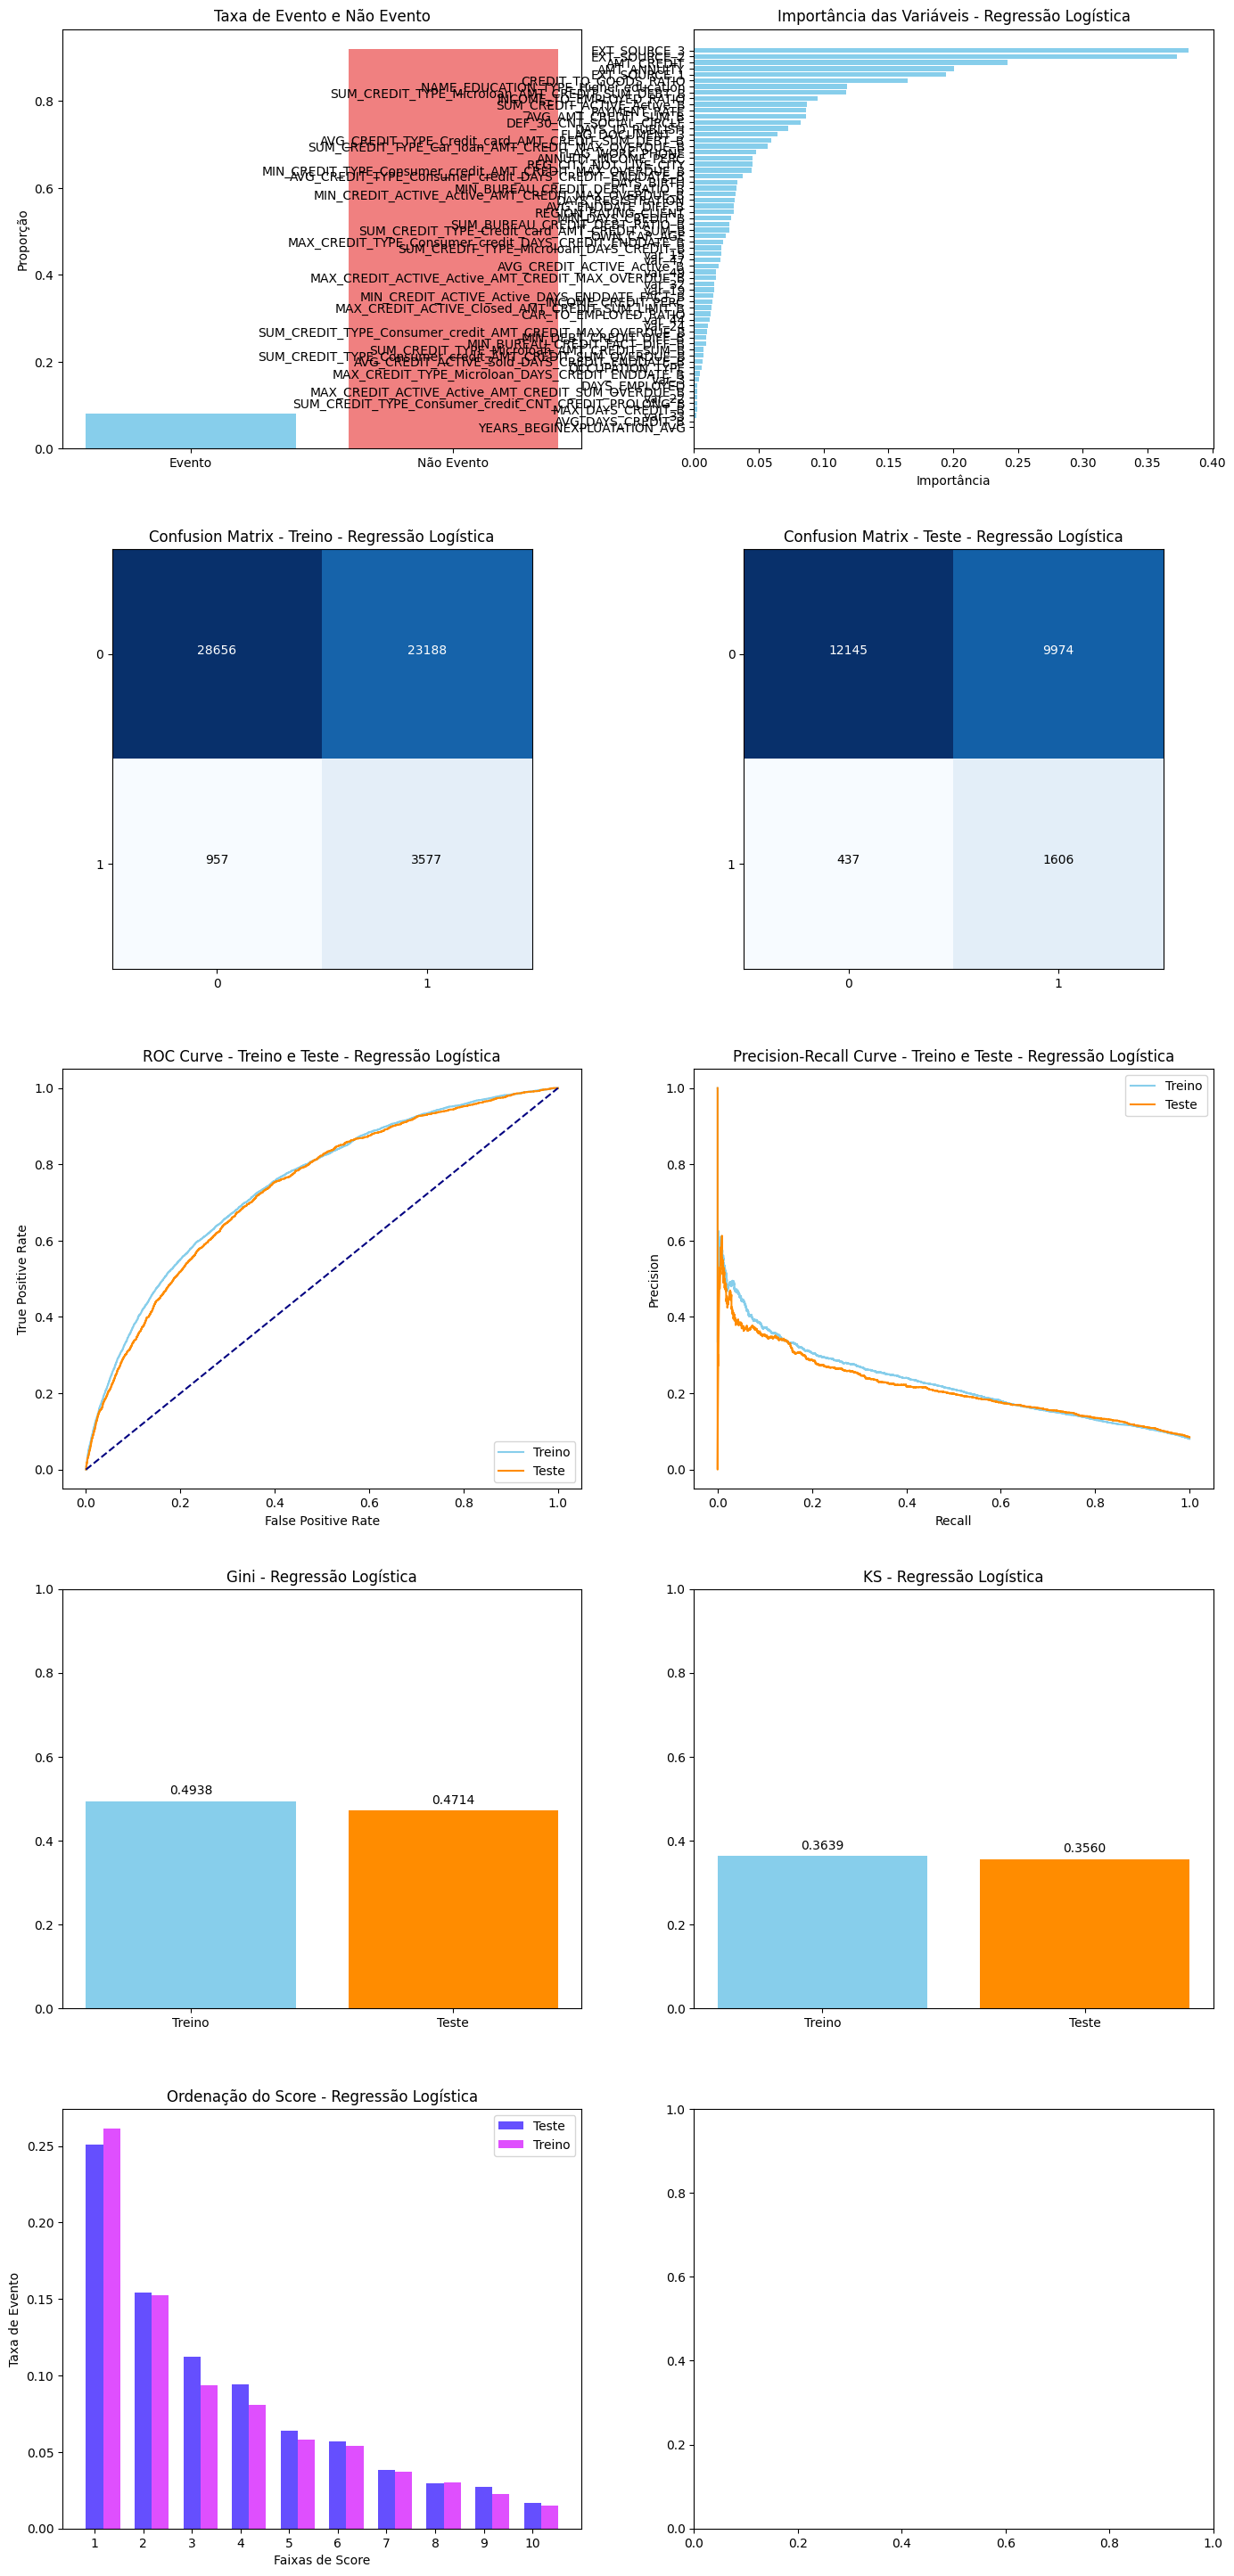

In [115]:
# # loading model

# já treinado anteriormente
# with open(f'{root_path}/{parent_folder_name}/PKL/model_{parent_folder_name}.pkl', 'rb') as f:
#     best_model = pickle.load(f)

best_model = LogisticRegression(**params_, random_state=seed)
best_model.fit(X_train, y_train)

# analysing
avaliar_modelo(X_train, y_train, X_test, y_test, best_model, nm_modelo='Regressão Logística', root_path=root_path, parent_folder_name=parent_folder_name)

# 4. Saving model

In [116]:
# saving pickle of model
with open(f'{root_path}/{parent_folder_name}/PKL/model_{parent_folder_name}.pkl', 'wb') as file:
  pickle.dump(best_model, file)

In [ ]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [ ]:
y_predict = best_model.predict(X)
y_predict_proba = best_model.predict_proba(X)[:, 0]


In [ ]:
data_plot = X.copy()

data_plot['TARGET'] = y
data_plot['TARGET_PREDICT'] = y_predict
data_plot['TARGET_PREDICT_PROBA'] = y_predict_proba

# data_plot['TARGET_PREDICT_PROBA_BINS'] = pd.cut(data_plot['TARGET_PREDICT_PROBA'], bins=10)
data_plot['TARGET_PREDICT_PROBA_BINS'] = pd.qcut(data_plot['TARGET_PREDICT_PROBA'], q=10)

data_plot = data_plot[['TARGET', 'TARGET_PREDICT', 'TARGET_PREDICT_PROBA', 'TARGET_PREDICT_PROBA_BINS']]

# data_plot = data_plot.reset_index(drop=True)
# data_plot['TARGET_PREDICT_PROBA_BINS'] = pd.qcut(data_plot.index, q=10)
data_plot['TARGET_PREDICT_PROBA_BINS'] = data_plot['TARGET_PREDICT_PROBA_BINS'].astype(str)

data_plot

,TARGET,TARGET_PREDICT,TARGET_PREDICT_PROBA,TARGET_PREDICT_PROBA_BINS
0,0,0,0.645846,"(0.612, 0.665]"
1,0,1,0.325395,"(0.255, 0.338]"
2,1,1,0.434437,"(0.403, 0.459]"
3,0,0,0.830837,"(0.73, 0.997]"
4,0,0,0.527200,"(0.512, 0.562]"
...,...,...,...,...
24157,0,1,0.476564,"(0.459, 0.512]"
24158,0,1,0.296391,"(0.255, 0.338]"
24159,0,0,0.790226,"(0.73, 0.997]"
24160,0,1,0.469192,"(0.459, 0.512]"


In [ ]:
# data_plot.to_excel(f'{root_path}/{parent_folder_name}/DATAS/df_predicted_values_{parent_folder_name}.xlsx')

In [ ]:
df = data_plot.groupby('TARGET_PREDICT_PROBA_BINS').agg(
    total_linhas = ('TARGET', 'count'),
    bad_linhas = ('TARGET', 'sum')
)

df = df.reset_index()

df

,TARGET_PREDICT_PROBA_BINS,total_linhas,bad_linhas
0,"(-0.00099999345, 0.255]",8054,2080
1,"(0.255, 0.338]",8054,1232
2,"(0.338, 0.403]",8054,804
3,"(0.403, 0.459]",8054,681
4,"(0.459, 0.512]",8054,488
5,"(0.512, 0.562]",8054,430
6,"(0.562, 0.612]",8054,308
7,"(0.612, 0.665]",8054,241
8,"(0.665, 0.73]",8054,189
9,"(0.73, 0.997]",8054,124


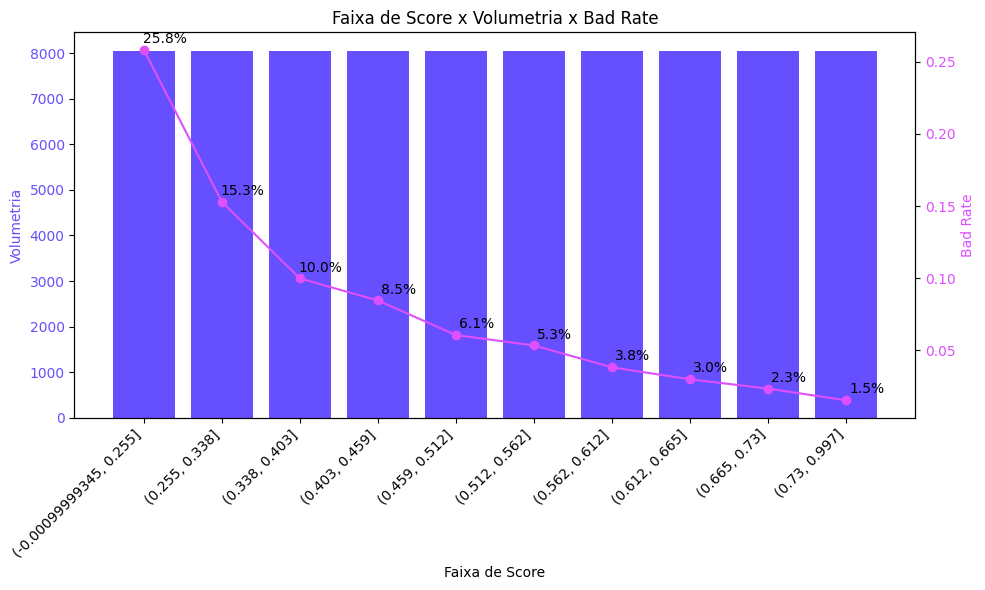

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcule a Bad Rate (taxa de ocorrência ruim)
df['bad_rate'] = df['bad_linhas'] / df['total_linhas']

# Crie uma figura e eixos
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barra para a contagem de linhas
ax1.bar(df['TARGET_PREDICT_PROBA_BINS'], df['total_linhas'], color='#654ffe', label='Total de Linhas')
ax1.set_xlabel('Faixa de Score')
ax1.set_ylabel('Volumetria', color='#654ffe')
ax1.tick_params(axis='y', labelcolor='#654ffe')
ax1.set_xticklabels(df['TARGET_PREDICT_PROBA_BINS'], rotation=45, ha='right')

# Crie um segundo eixo para o gráfico de linha (Bad Rate)
ax2 = ax1.twinx()
ax2.plot(df['TARGET_PREDICT_PROBA_BINS'], df['bad_rate'], color='#df4ffe', marker='o', label='Bad Rate')
ax2.set_ylabel('Bad Rate', color='#df4ffe')
ax2.tick_params(axis='y', labelcolor='#df4ffe')

# Adicione os valores de Bad Rate junto aos pontos no gráfico
for i, txt in enumerate(df['bad_linhas'] / df['total_linhas']):
    ax2.annotate(
        f'{txt:.1%}',
        (df['TARGET_PREDICT_PROBA_BINS'][i], df['bad_linhas'][i] / df['total_linhas'][i]),
        textcoords="offset points",
        xytext=(15, 5),
        ha='center'
    )

# Adicione títulos e legendas
plt.title('Faixa de Score x Volumetria x Bad Rate')
fig.tight_layout()
plt.show()

In [ ]:
# import statsmodels.api as sm

# logit_model = sm.Logit(y_train, X_train, **params_)
# result = logit_model.fit()
# result.summary().tables[1]
# pd.DataFrame(result.summary().tables[1]).to_csv(f'{root_path}/{parent_folder_name}/DATAS/df_feature_coef_{parent_folder_name}.csv')

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# pd.DataFrame({
#     'variables': X_train.columns,
#     'betas': best_model.coef_[0]
# }).to_csv(f'{root_path}/{parent_folder_name}/DATAS/df_feature_betas_{parent_folder_name}.csv')